# Lecture 2 notebook

### Import packages 

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import warnings
warnings.filterwarnings('ignore')

The "XOR" (or "exclusive OR") problem is often used to illustrate the ability of neural networks to fit complicated functions. The XOR problem has a checkerboard structure:

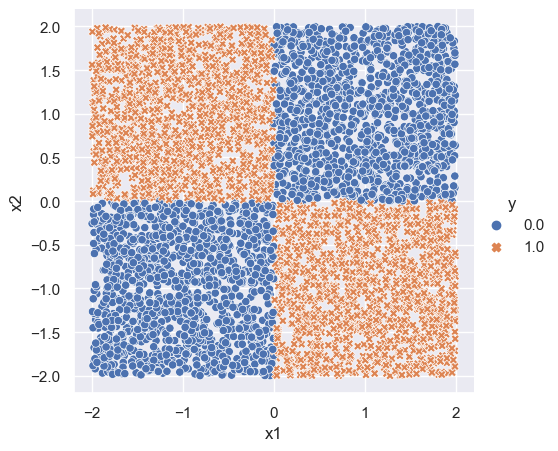

In [28]:
# xor ------------------------------------
n = 5000
p = 2
x = np.random.uniform(-2, 2, size=(n, p))

y = ((x[:,0] < 0) & (x[:, 1] > 0)).astype(x.dtype) + ((x[:,0] > 0) & (x[:, 1] < 0)).astype(x.dtype)

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme()
xor_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
xor_plot.fig.subplots_adjust(top=.9)

Logistic regression can only fit linear decision boundaries, and so fails the XOR problem.

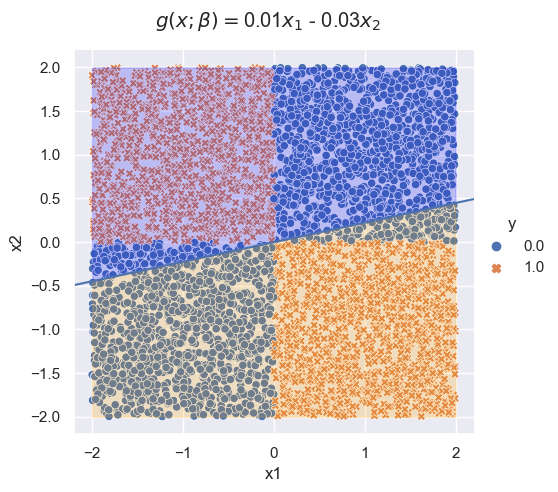

In [3]:
## logitstic regression doesn't work
log_fit = LogisticRegression()
log_fit.fit(x, y)
coeffs = log_fit.coef_[0]
coeff = -coeffs[0]/coeffs[1]

## plot
logit_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
plt.axline([0,0], slope=coeff)
## title
logit_plot.fig.subplots_adjust(top=.9)
logit_plot.fig.suptitle(r'$g(x;\beta) = $' + str(round(coeffs[0], 2)) + r'$x_1$ - ' + str(round(-coeffs[1], 2)) + r'$x_2$')
## fill in area
x_fill = np.linspace(-2, 2, num=200)
y_line = coeff * x_fill
logit_plot.ax.fill_between(x_fill, y_line, 2, color='blue', alpha=0.2)
logit_plot.ax.fill_between(x_fill, -2, y_line, color='orange', alpha=0.2)

## Neural networks

Let's set up a 1-layer neural network to solve the XOR problem.

For deep learning, we use the `torch` package, available at https://pytorch.org.

### Neural network classes in PyTorch

`torch` provides a base class called `nn.Module`. 

When we set up a neural network, we sub-class `nn.Module`.

Here is an example of a neural network in `torch` named `XORNet`.

In [4]:
class XORNet(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super(XORNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()) # y_pred is between 0 and 1

    def forward(self, x):
        y = self.sequential(x) # output is samples x 1 matrix
        y = torch.flatten(y) # output is samples vector
        return y

    def loss_fn(self, y, y_pred):
        loss = y * torch.log(y_pred + 1e-8) + (1-y) * torch.log(1-y_pred + 1e-8)
        output = -loss.sum()
        return output

The `class` statement identifies the code chunk as a declaration for a class `XORNet` that inherits from the base class `nn.Module`. This base class is ubiquitous in torch and represents the mappings in the neural networks.

Indented beneath the class statement are the methods of this class: in this case `__init__`, `forward` and `loss_fn`. The `__init__` method is called when an instance of the class is created. In the methods, self always refers to an instance of the class. In the `__init__` method, we have attached an object to self as an attribute: sequential, that defines the neural network architecture.

There is one additional line in the `__init__` method, which is a call to `super()`. This function allows subclasses (i.e. `XORNet`) to access methods of the class they inherit from. For example, the class `nn.Module` has its own `__init__` method, which is different from the `XORNet.__init__()` method we’ve written above. Using `super()` allows us to call the method of the base class. For torch models, we will always be making this `super()` call as it is necessary for the model to be properly interpreted by torch.

The function `forward` is called when the neural network is run on input data.

(above explanation adapted from https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch10-deeplearning-lab.ipynb)

In [44]:
hidden_dim=10
model = XORNet(input_dim=p, hidden_dim=hidden_dim)

In [30]:
model

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

### Data
For torch to read the data, it needs to be a `torch.tensor` type:

In [31]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)

We combine `x_train` and `y_train` into a `TensorDataset`, a dataset recognizable by torch. `TensorDataset` stores the samples and their labels. It is a subclass of the more general `torch.utils.data.Dataset`, which you can customize for non-standard data.

In [32]:
train_data = TensorDataset(x_train, y_train)

In [41]:
x_temp, y_temp = train_data[0]

In [42]:
x_temp

tensor([-0.1896, -0.5401])

`TensorDataset` is helpful as it can be passed to `DataLoader()`. `DataLoader` wraps an iterable around the `Dataset` class to enable easy access to the samples. This is very helpful for implementing stochastic gradient descent, where we iterate over subsets (batches) of the data.

In [38]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

In [39]:
ypred = model(x_train)
cur_loss = model.loss_fn(y_train, ypred)
print(ypred.shape)
print(cur_loss)

torch.Size([5000])
tensor(3932.8311, grad_fn=<NegBackward0>)


### Training
We now set up the optimizer for training. We use Adam, and a base learning rate of `lr=0.01`. We set the number of epochs to 100. (Rule of thumb: pick largest `lr` that still results in convergence)

In [45]:
lr = 0.01 # multiply this by the learning rate computed by Adam (eta_0)
epochs = 300 

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Now we train the model:

In [46]:
for epoch in range(epochs):
    
    # in each epoch, iterate over all batches of data (easily accessed through train_loader)
    epoch_loss = 0

    for x_batch, y_batch in train_loader:

        # calculate gradient over batch

        pred = model(x_batch)                   # this is the output from the forward function
        loss = model.loss_fn(y_batch, pred)     # calculate loss function

        loss.backward()                         # computes gradients wrt loss function

        # update parameters in direction of gradient

        optimizer.step()                        # updates parameters 

        optimizer.zero_grad()                   # set the gradients back to zero (otherwise grads are accumulated)

        epoch_loss += loss.item() # grabs just numeric value of loss

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}")


epoch:  0 loss: 2.8e+03
epoch:  10 loss: 3.92e+02
epoch:  20 loss: 2.72e+02
epoch:  30 loss: 2.09e+02
epoch:  40 loss: 1.78e+02
epoch:  50 loss: 1.58e+02
epoch:  60 loss: 1.44e+02
epoch:  70 loss: 1.33e+02
epoch:  80 loss: 1.27e+02
epoch:  90 loss: 1.22e+02
epoch:  100 loss: 1.14e+02
epoch:  110 loss: 1.1e+02
epoch:  120 loss: 1.11e+02
epoch:  130 loss: 1.05e+02
epoch:  140 loss: 1.01e+02
epoch:  150 loss: 96.9
epoch:  160 loss: 99.3
epoch:  170 loss: 95.0
epoch:  180 loss: 92.0
epoch:  190 loss: 92.0
epoch:  200 loss: 89.6
epoch:  210 loss: 83.8
epoch:  220 loss: 89.2
epoch:  230 loss: 83.0
epoch:  240 loss: 85.4
epoch:  250 loss: 85.2
epoch:  260 loss: 82.6
epoch:  270 loss: 83.3
epoch:  280 loss: 80.7
epoch:  290 loss: 80.0


To visualize the end result, we plot the predicted values over the whole space (the decision surface).

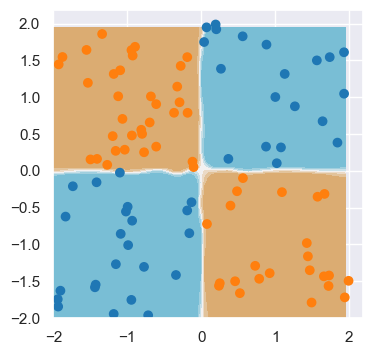

In [47]:
x1 = np.arange(-2, 2, 0.05)
x2 = np.arange(-2, 2, 0.05)

x_test_np = np.array([(i, j) for i in x1 for j in x2])
y_test_np = ((x_test_np[:,0] < 0) & (x_test_np[:, 1] > 0)).astype(x_test_np.dtype) + ((x_test_np[:,0] > 0) & (x_test_np[:, 1] < 0)).astype(x_test_np.dtype)

x_test = torch.tensor(x_test_np, dtype=torch.float)
y_test = torch.tensor(y_test_np)


model.eval()
y_pred = model(x_test)

y_pred_np = y_pred.detach().numpy()
y_pred_np = y_pred_np.reshape(x1.shape[0], x2.shape[0])

seaborn_cols = sns.color_palette("tab10")
cols = [seaborn_cols[int(i)] for i in y]

custom_cmap = sns.diverging_palette(220, 50, s=70, l=70, as_cmap=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.contourf(x1, x2, y_pred_np, cmap=custom_cmap)
ax.scatter(x[0:100,0], x[0:100,1], c=cols[0:100])
fig.savefig('xor_nn_d_' + str(hidden_dim) + '.png')

Play around with different sizes of `hidden_dim` and see the difference!

## MNIST example

We use `torchvision.datasets` to download the MNIST data.

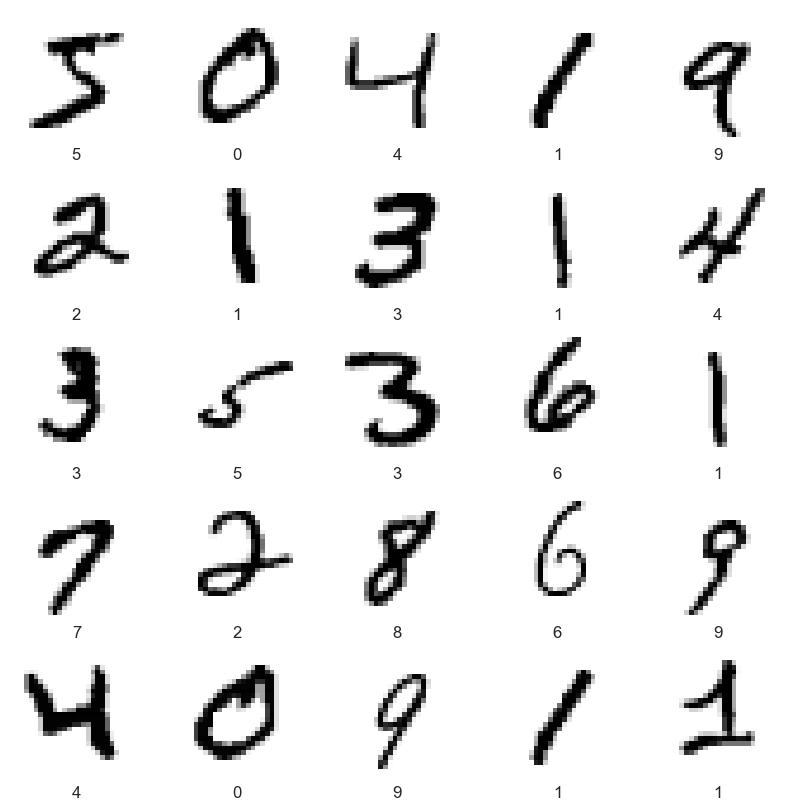

In [48]:
(mnist_train,
 mnist_test) = [torchvision.datasets.MNIST(root='data',
                      train=train,
                      download=True,
                      transform=torchvision.transforms.ToTensor())
                for train in [True, False]]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_image, label = mnist_train[i]
    plt.imshow(train_image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

Set up our dataloaders.

In [54]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)

Let's define our neural network for the MNIST classification problem.

In [49]:
class MNISTNet(nn.Module):

    def __init__(self):
        super(MNISTNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 256), # x is a 28x28 pixel image
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10), # want to predict 0 - 9
            nn.Softmax() # makes sure our 10-vector sums to one -- assign probability to each of 0, 1, 2,..., 9
        )

    def forward(self, x):
        prob = self.layers(x)
        return prob

    def loss_fn(self, y, y_pred):
        log_pred = torch.log(y_pred + 1e-8)
        loss = -(log_pred * y).sum(1).mean()
        return loss

Instantiate our model:

In [50]:
model = MNISTNet()

In [56]:
x_batch, y_batch = next(iter(train_loader))

In [60]:
x_batch.shape # N x C x H x W
# N: number of samples
# C: channels -- RGB images will have 3 channels 
# H: height
# W: width

torch.Size([64, 1, 28, 28])

In [61]:
x_batch = x_batch.reshape(x_batch.shape[0], 28*28) # turn into [64, 28*28] tensor 

In [62]:
x_batch.shape

torch.Size([64, 784])

In [63]:
x_batch[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [58]:
y_batch.shape # N

torch.Size([64])

In [64]:
y_batch = F.one_hot(y_batch, num_classes=10) # turn into 64 x 10 matrix

In [65]:
y_batch

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],


Train our model:

In [66]:
lr = 0.001
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    
    for x_batch, y_batch in train_loader:

        # x_batch is a 28 x 28 dim matrix
        # need to turn it into a 28*28 vector
        x_batch = x_batch.reshape(x_batch.shape[0], 28*28)

        # one hot encoding for y_batch
        y_batch = F.one_hot(y_batch, num_classes=10)


        
        y_pred = model(x_batch)
        loss = model.loss_fn(y_batch, y_pred)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

epoch:  0 loss: 0.0543
epoch:  10 loss: 0.00382
epoch:  20 loss: 6.63e-05
epoch:  30 loss: 0.00221
epoch:  40 loss: 1.25e-06


Calculate our accuracy:

In [67]:
model.eval()
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.reshape(x_batch.shape[0], 28 * 28)
y_pred_array = model(x_batch)
y_pred = torch.argmax(y_pred_array, axis=1)
acc = (y_pred == y_batch).sum()
acc = acc / len(y_pred)

In [68]:
acc

tensor(0.9798)

Let's look at some interesting results (code adapted from https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_mnist_tf.ipynb)

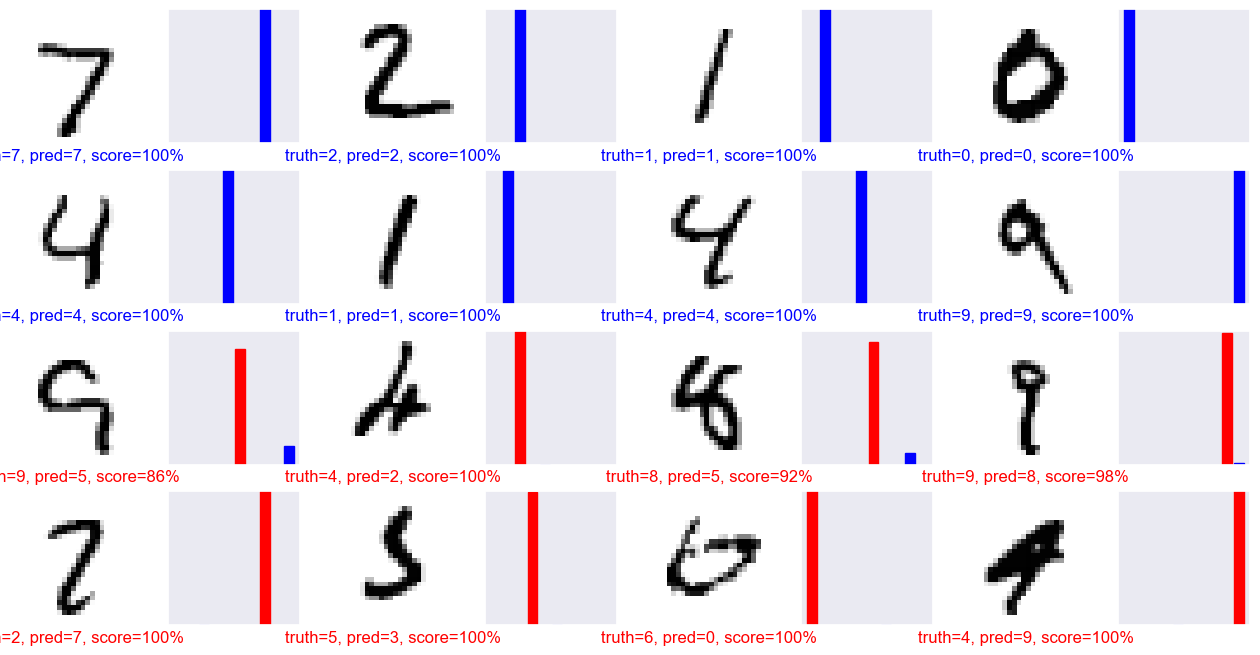

In [69]:
# find interesting test images
errors = torch.where(y_pred != y_batch)[0]
inds1 = range(8)
inds2 = errors[:8]
inds = np.concatenate((inds1, inds2))

pred_array = y_pred_array.detach().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    n = inds[i]
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = mnist_test[n]
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
    predicted_label = y_pred[n]
    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("truth={}, pred={}, score={:2.0f}%".format(
        label,
        predicted_label,
        100 * np.max(pred_array[n])),
        color=color)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), pred_array[n], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(pred_array[n])
    thisplot[predicted_label].set_color('red')
    thisplot[label].set_color('blue')

### Heteroskedastic regression (adapted from https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_1d_regression_hetero_tfp.ipynb)

In [70]:
# Make data

x_range = [-20, 60]  # test
x_ranges = [[-20, 60]]
ns = [1000]

def load_dataset():
    def s(x):  # std of noise
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 0.25 + g**2.0

    x = []
    y = []
    for i in range(len(ns)):
        n = ns[i]
        xr = x_ranges[i]
        x1 = np.linspace(xr[0], xr[1], n)
        eps = np.random.randn(n) * s(x1)
        y1 = (1 * np.sin(0.2 * x1) + 0.1 * x1) + eps
        x = np.concatenate((x, x1))
        y = np.concatenate((y, y1))
    # print(x.shape)
    x = x[..., np.newaxis]
    n_test = 150
    x_test = np.linspace(*x_range, num=n_test).astype(np.float32)
    x_test = x_test[..., np.newaxis]
    return y, x, x_test

y, x, x_test = load_dataset()

### Define neural network

In [71]:
class HetNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims, mean_dims, var_dims):
        super(HetNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dims # for the backbone layers -- this should be a list e.g. [20, 20, 20]
        self.mean_dims = mean_dims # for the mean layers
        self.var_dims = var_dims # for the variance layer

        # create backbone
        current_dim = input_dim
        self.layers = nn.ModuleList() # before we used nn.sequential
        for i in range(len(hidden_dims)):
            hdim = hidden_dims[i]
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        # create heads
        core_dim = hidden_dims[-1]
        current_dim = core_dim
        self.mean_layers = nn.ModuleList()
        for i in range(len(mean_dims)):
            hdim = mean_dims[i]
            self.mean_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.mean_layers.append(nn.Linear(current_dim, output_dim))

        current_dim = core_dim
        self.var_layers = nn.ModuleList()
        for i in range(len(var_dims)):
            hdim = var_dims[i]
            self.var_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.var_layers.append(nn.Linear(current_dim, output_dim))

    def core_net(self, x):
        # takes x as input, outputs final hidden layer of backbone
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

    def mean_net(self, x):
        # takes in final hidden layer of backbone, outputs mean
        for layer in self.mean_layers[:-1]:
            x = F.relu(layer(x))
        x = self.mean_layers[-1](x)
        return x

    def var_net(self, x):
        for layer in self.var_layers[:-1]:
            x = F.relu(layer(x))
        x = self.var_layers[-1](x) # output of linear layer -- this is a real-valued tensor
        return x

    def forward(self, x):
        mean = self.mean_net(self.core_net(x))
        log_var = self.var_net(self.core_net(x))

        return mean, log_var

    def loss_fn(self, x, y):
        mean, log_var = self.forward(x)
        var = torch.exp(log_var)

        loss = torch.pow(y-mean, 2) / var + log_var # y needs to be a matrix n x 1 not a vector n
        out = loss.mean()

        return out

Set up data

In [72]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)
y_train = y_train.unsqueeze(-1)

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

In [73]:
y_train.shape

torch.Size([1000, 1])

Initialize model

In [74]:
hidden_dims = [50, 50]
mean_dims = [20]
var_dims = [20]
model = HetNet(input_dim=1, output_dim=1, hidden_dims=hidden_dims, mean_dims=mean_dims, var_dims=var_dims)

Train

In [75]:
lr = 0.001
epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:

        loss = model.loss_fn(x_batch, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 50 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

epoch:  0 loss: 0.353
epoch:  50 loss: -0.0402
epoch:  100 loss: -0.56
epoch:  150 loss: -0.465
epoch:  200 loss: 0.417
epoch:  250 loss: -0.809
epoch:  300 loss: -0.817
epoch:  350 loss: -1.41
epoch:  400 loss: -1.07
epoch:  450 loss: -0.638


Plot results

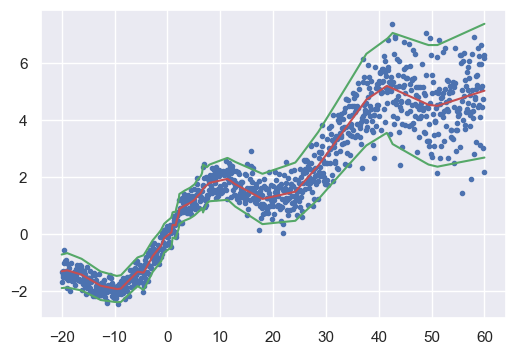

In [76]:
model.eval()
mean, log_var = model(x_train)
sd = torch.exp(0.5 * log_var)
mean_np = mean.detach().numpy()
sd_np = sd.detach().numpy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
ax.plot(x, y, '.', label="observed")
ax.plot(x, mean_np, 'r-')
ax.plot(x, mean_np + 2 * sd_np, 'g-')
ax.plot(x, mean_np - 2 * sd_np, 'g-')